#Task 1: Tabular Q-Learning Update

In [1]:
import numpy as np

Defining q table as a a NumPy array of zeros with shape (n_states​,n_actions​).

In [2]:
def init_q_table(n_states,n_actions):
  return np.zeroes((n_states,n_actions))

Defining function to update q table

In [3]:
def q_update(Q, s, a, r, s_next, alpha, gamma):
  max_q_next=np.max(Q[s_next])
  Q[s,a]=Q[s,a]+alpha*[r+gamma*max_q_next-Q[s,a]]
  return Q

#Task 2: ε-Greedy Policy on a Custom GridWorld

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random

Defining the Grid environment (4*4 grid) with two terminal states (with reward 100 and -100) and default reward for each step as -1. The action space includes up/down/left/right actions.

In [30]:
actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
class GridEnv:
  def __init__(self):
    self.width=4
    self.height=4
    self.victory=(3,3)
    self.reset()

  def reset(self):
    self.agent=self.random_empty_cell()
    self.reward=0
    self.done=False
    return self.agent

  def random_empty_cell(self):
    while True:
      pos = (random.randint(0, self.width - 1), random.randint(0, self.height - 1))
      return pos

  def step(self,action):
    x, y = self.agent
    if action=='UP':
      y-= 1
    elif action=='DOWN':
      y+= 1
    elif action=='LEFT':
      x-= 1
    elif action=='RIGHT':
      x+= 1
    new_pos = (x, y)
    if 0 <=x<self.width and 0<=y< self.height and new_pos:
      self.agent= new_pos
    reward = -1
    done= False

    if self.agent== self.victory:
      reward= 100
      done= True
    return self.agent,reward,done

Defining the Q_table learning function using epsilon greedy policy where with probability epsilon select a random action while with probability 1−epsilon, select the action with the highest Q-value for the given state.

In [31]:
alpha= 0.1
gamma= 0.9

def init_q_table(n_states,n_actions):
  return np.zeros((n_states,n_actions))

def q_update(Q, s, a, r, s_next, alpha, gamma):
  max_q_next=np.max(Q[s_next])
  Q[s,a]=Q[s,a]+alpha*(r+ gamma*max_q_next -Q[s,a])
  return Q

def select_action(Q, state,epsilon):
  if np.random.rand()< epsilon:
    return random.randint(0,len(actions)-1)
  else:
    return np.argmax(Q[state])

def q_learning(env,epsilon):
  Q=init_q_table(16,4)
  reward_per_episode=[]
  episode_count=0
  num_episodes=500
  total_reward=0
  while episode_count< num_episodes:
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
      state_index = state[0]*env.width + state[1]
      action_index=select_action(Q,state_index,epsilon)
      action= actions[action_index]
      next_state,reward,done = env.step(action)
      next_state_index=next_state[0]*env.width + next_state[1]
      q_update(Q,state_index,action_index,reward,next_state_index,alpha,gamma)
      state= next_state
      total_reward += reward

    reward_per_episode.append(total_reward)
    episode_count+=1
    if episode_count%50==0:
      print(f"episode {episode_count} done")

  return reward_per_episode


Training and updating the Q_table. Ploting moving average of reward over 50 episodes with different epsilon.

episode 50 done
episode 100 done
episode 150 done
episode 200 done
episode 250 done
episode 300 done
episode 350 done
episode 400 done
episode 450 done
episode 500 done
episode 50 done
episode 100 done
episode 150 done
episode 200 done
episode 250 done
episode 300 done
episode 350 done
episode 400 done
episode 450 done
episode 500 done


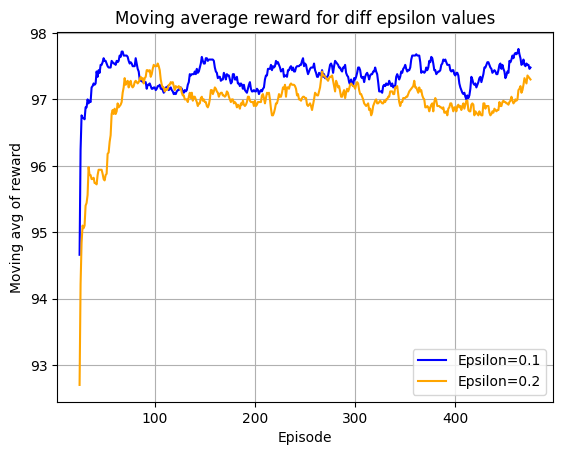

In [32]:
env = GridEnv()
rewards1= q_learning(env,0.1)
rewards2= q_learning(env,0.2)
window_size =50
moving_average_reward1= np.convolve(rewards1, np.ones(window_size)/window_size, mode='valid')
moving_average_reward2= np.convolve(rewards2, np.ones(window_size)/window_size, mode='valid')

episodes = np.arange(len(moving_average_reward1)) + window_size // 2
plt.plot(episodes,moving_average_reward1,label='Epsilon=0.1',color='blue')
plt.plot(episodes,moving_average_reward2,label='Epsilon=0.2',color='orange')
plt.xlabel('Episode')
plt.ylabel('Moving avg of reward')
plt.title('Moving average reward for diff epsilon values')
plt.legend()
plt.grid(True)
plt.show()


Epsilon=0.1 shows better moving average reward

Lower epsilon means less exploration, more exploitation once a good policy is learned.

At the start, exploration is valuable — hence both curves rise.

But over time, excessive exploration (epsilon=0.2) leads to occasional random moves, causing dips and a lower average reward.

Epsilon=0.1 strikes a better balance by exploring enough at the start, then focusing on exploiting the best known actions.



#Task 3: Experience Replay Buffer

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

Creating a class of ReplayBuffer

In [9]:
class ReplayBuffer():
  def __init__(self,capacity):
    self.memory=deque([],maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    transition = (state, action, reward, next_state, done)
    self.memory.append(transition)

  def sample(self,batch_size):
    batch= random.sample(self.memory,batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    return (np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones,dtype=np.uint8))


  def __len__(self):
    return len(self.memory)


Buffer Demonstration

In [10]:
buffer = ReplayBuffer(capacity=100)
for i in range(100):
  state=random.randint(0,15)
  action=random.randint(0,3)
  reward=random.uniform(-1.0,100.0)
  next_state=random.randint(0,15)
  done=random.choice([True, False])
  buffer.push(state, action, reward, next_state, done)

states, actions, rewards, next_states, dones = buffer.sample(32)

print("States shape:", states.shape, "dtype:", states.dtype)
print("Actions shape:", actions.shape, "dtype:", actions.dtype)
print("Rewards shape:", rewards.shape, "dtype:", rewards.dtype)
print("Next_states shape:", next_states.shape, "dtype:", next_states.dtype)
print("Dones shape:", dones.shape, "dtype:", dones.dtype)

States shape: (32,) dtype: int64
Actions shape: (32,) dtype: int64
Rewards shape: (32,) dtype: float32
Next_states shape: (32,) dtype: int64
Dones shape: (32,) dtype: uint8


#Task 4: Deep Q-Network with Target Copy

In [11]:
import numpy as np
import torch
from torch import nn

In [12]:
class DQNPolicy(nn.Module):
  def __init__(self, N_input, N_output, N_hidden=128):
    super().__init__()
    activation=nn.ReLU()   #using Relu activation function
    self.fcs = nn.Sequential(nn.Linear(N_input, N_hidden))

    self.fch= nn.Sequential(nn.Linear(N_hidden, N_hidden),
                            activation,
                            nn.Linear(N_hidden, N_hidden))

    self.fce= nn.Linear(N_hidden,N_output)
  def forward(self,x):
    x=self.fcs(x)
    x=self.fch(x)
    x=self.fce(x)
    return x

In [13]:
class DQNTarget(nn.Module):
  def __init__(self, N_input, N_output, N_hidden=128):
    super().__init__()
    activation=nn.ReLU()   #using Relu activation function
    self.fcs = nn.Sequential(nn.Linear(N_input, N_hidden))

    self.fch= nn.Sequential(nn.Linear(N_hidden, N_hidden),
                            activation,
                            nn.Sequential(nn.Linear(N_hidden, N_hidden)))

    self.fce= nn.Linear(N_hidden,N_output)
  def forward(self,x):
    x=self.fcs(x)
    x=self.fch(x)
    x=self.fce(x)
    return x

Function that copies the weights from the policy_net to the target_net

In [14]:
def update_target(policy_net, target_net):
  target_net.load_state_dict(policy_net.state_dict())

#Task 5: Full DQN Training Loop on CartPole-v1

In [15]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from collections import deque
import random
import torch.nn.functional as F


CartPole-v1 environment

In [16]:
env= gym.make("CartPole-v1")
N_input= env.observation_space.shape[0]
N_output= env.action_space.n

Initialize DQNPolicy and DQNTarget networks

In [17]:
class DQNPolicy(nn.Module):
  def __init__(self, N_input, N_output, N_hidden=128):
    super().__init__()
    activation=nn.ReLU()   #using Relu activation function
    self.fcs = nn.Sequential(nn.Linear(N_input, N_hidden))

    self.fch= nn.Sequential(nn.Linear(N_hidden, N_hidden),
                            activation,
                            nn.Linear(N_hidden, N_hidden))

    self.fce= nn.Linear(N_hidden,N_output)
  def forward(self,x):
    x=self.fcs(x)
    x=self.fch(x)
    x=self.fce(x)
    return x

In [18]:
class DQNTarget(nn.Module):
  def __init__(self, N_input, N_output, N_hidden=128):
    super().__init__()
    activation=nn.ReLU()   #using Relu activation function
    self.fcs = nn.Sequential(nn.Linear(N_input, N_hidden))

    self.fch= nn.Sequential(nn.Linear(N_hidden, N_hidden),
                            activation,
                            nn.Linear(N_hidden, N_hidden))

    self.fce= nn.Linear(N_hidden,N_output)
  def forward(self,x):
    x=self.fcs(x)
    x=self.fch(x)
    x=self.fce(x)
    return x

In [19]:
def update_target(policy_net, target_net):
  target_net.load_state_dict(policy_net.state_dict())

In [20]:
policy_net= DQNPolicy(N_input, N_output)
target_net= DQNTarget(N_input, N_output)
update_target(policy_net, target_net)

optimizer= torch.optim.Adam(policy_net.parameters(),lr=1e-3)

loss_fn= nn.MSELoss()

Initialize ReplayBuffer

In [21]:
class ReplayBuffer():
  def __init__(self,capacity):
    self.memory=deque([],maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    transition = (state, action, reward, next_state, done)
    self.memory.append(transition)

  def sample(self,batch_size):
    batch= random.sample(self.memory,batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    return (np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones,dtype=np.uint8))


  def __len__(self):
    return len(self.memory)

buffer_capacity= 10000
replay_buffer= ReplayBuffer(buffer_capacity)

Training Loop

In [22]:
#Hyperparameters
N_episodes=500
batch_size=64
gamma=0.99
epsilon_start=1.0
epsilon_end=0.01
M=N_episodes  # epsilon decay rate over episodes
update_target_every=20

#training loop
rewards_per_episode=[]
success_count=0

for episode in range(N_episodes):
  state=env.reset()[0]
  done =False

  epsilon= epsilon_end+(epsilon_start-epsilon_end)*(1- episode/M)
  total_reward=0

  while not done:
    #epsilon greedy policy
    if random.random()< epsilon:
      action= env.action_space.sample()
    else:
      state_tensor= torch.FloatTensor(state).unsqueeze(0)
      q_values= policy_net(state_tensor)
      action= q_values.argmax().item()
    next_state,reward,done,truncated, _ = env.step(action)
    total_reward+=reward
    #store in replay buffer
    replay_buffer.push(state, action,reward, next_state, done)
    state=next_state
    # Train if buffer has enough samples
    if len(replay_buffer) >= batch_size:
      states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

      states = torch.FloatTensor(states)
      actions = torch.LongTensor(actions)
      rewards = torch.FloatTensor(rewards)
      next_states = torch.FloatTensor(next_states)
      dones = torch.FloatTensor(dones)

      # Compute Q-values
      q_values= policy_net(states)
      q_values= q_values.gather(1, actions.unsqueeze(1)).squeeze()    #picks the Q-value corresponding to the action that was actually taken

      # Compute target Q-values
      with torch.no_grad():
        next_q_values= target_net(next_states).max(1)[0]   #takes the maximum Q-value over all possible actions for each next state
        target_q_values= rewards+ gamma* next_q_values* (1 - dones)   #zero out the future reward if the episode terminated at this step

      # Compute loss
      loss= loss_fn(q_values,target_q_values)

      # Gradient step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  rewards_per_episode.append(total_reward)

  # Success tracking
  if total_reward>= 195:
    success_count+= 1

  # Update target network
  if (episode+1)%update_target_every==0:
    update_target(policy_net, target_net)

  if (episode+ 1)%50==0:
    print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

Episode 50, Reward: 47.0, Epsilon: 0.903
Episode 100, Reward: 22.0, Epsilon: 0.804
Episode 150, Reward: 13.0, Epsilon: 0.705
Episode 200, Reward: 26.0, Epsilon: 0.606
Episode 250, Reward: 39.0, Epsilon: 0.507
Episode 300, Reward: 63.0, Epsilon: 0.408
Episode 350, Reward: 160.0, Epsilon: 0.309
Episode 400, Reward: 331.0, Epsilon: 0.210
Episode 450, Reward: 140.0, Epsilon: 0.111
Episode 500, Reward: 143.0, Epsilon: 0.012


Plot Moving average reward

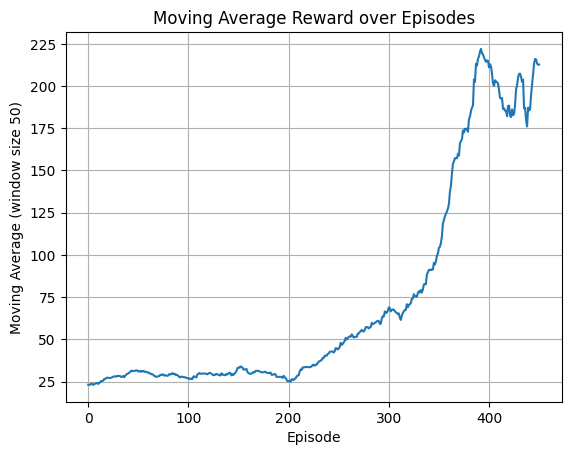

Final success rate: 8.20% of episodes reached >= 195 reward.


In [23]:
import matplotlib.pyplot as plt
# Moving average of rewards
window_size= N_episodes// 10
moving_avg= np.convolve(rewards_per_episode, np.ones(window_size)/ window_size, mode='valid')

# Plot
plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel(f'Moving Average (window size {window_size})')
plt.title('Moving Average Reward over Episodes')
plt.grid(True)
plt.show()

# Final success rate
success_rate= (success_count/N_episodes)* 100
print(f"Final success rate: {success_rate:.2f}% of episodes reached >= 195 reward.")